# Machine Vision - Assignment 8: ViT Implementation

This exercise will follow assignment 7 in structure. However, its goal is to get used to implement state-of-the-art architectures based on reading a paper.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision
from torchvision.transforms import v2

##### Preparation

##### German Traffic Sign Recognition Benchmark

The German Traffic Sign Recognition Benchmark [(GTSRB)](https://benchmark.ini.rub.de/) is a competition that was held at the IJCNN 2011. In this competition images of traffic signs should be classified.
You will implement your own neural network to classify a subset of the GTSRB dataset. This subset consists of `12` different classes, which are shown in the figures below. However, you are free to extend your solution to the full dataset.


|---|------------------------------|-------------------------------|-------------------------------|-------------------------------|-------------------------------|-------------------------------|-------------------------------|-------------------------------|-------------------------------|--------------------------------|--------------------------------|--------------------------------|
|  ![Class 0](res/images/0.png) | ![Class 1](res/images/6.png) | ![Class 2](res/images/16.png) | ![Class 3](res/images/17.jpg) | ![Class 4](res/images/19.png) | ![Class 5](res/images/22.jpg) | ![Class 6](res/images/28.png) | ![Class 7](res/images/29.png) | ![Class 8](res/images/32.png) | ![Class 9](res/images/33.png) | ![Class 10](res/images/38.png) | ![Class 11](res/images/40.png) |
<br></br>

In order to simplify this exercise, the raw GTSRB images are already transformed into a dataset, where each image has the shape of `[C,H,W]` (Height x Width x Channels) with values ranging from `0-1`.
Furthermore, the dataset is split into a train-, validation- and test-dataset, where the train- and validation-datasets are provided.

In [2]:
NUM_CLASSES = 12

train_ds = torchvision.datasets.ImageFolder("data_train", transform=v2.Compose([
    v2.RandAugment(),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
]))

val_ds = torchvision.datasets.ImageFolder("data_val", transform=v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
]))

train_dl = DataLoader(dataset=train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(dataset=val_ds, batch_size=8, shuffle=False)

Which means, that each label is a vector of 12 entries, where only the entry of the class has the value $1$ and all others values are $0$The `torchvision.datasets.ImageFolder` is a simple way to represent classification datasets. For more information you can read it up here: [ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

Furthermore, the standard pytorch dataloader class is used to create an iterator based on an `torch.utils.data.Dataset` class.
Each iteration, the dataloader returns a batch of `x = [Bx3x32x32]` images and `y = [Bx12]` class labels, where B is the batch size.

There are different approaches to encode the class label. For further information you can read this blog entry [integer- or one-hot-encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).
In this exercise the labels are encoded in the integer format.

In [3]:
x_batch, y_batch = next(iter(train_dl))

# @student print the image and label shape of a batch
print(f"image shape: {x_batch.shape}")
print(f"label shape: {y_batch.shape}")

image shape: torch.Size([8, 3, 32, 32])
label shape: torch.Size([8])


label: 4


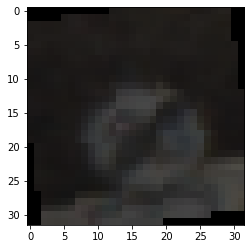

In [4]:
# @student show one image of the batch and its label
print(f"label: {y_batch[1]}")

plt.imshow(x_batch[0].permute(1,2,0))
plt.show()

### AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE

We will follow the steps of the ground braking paper "AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE" [Link to Publication](https://arxiv.org/abs/2010.11929)
which generalized the idea of language transformer models to vision tasks.

![vit_architecture](res/images/vit.png)


### Method

Before starting to implement the ViT please read the publication and shortly describe each of these steps:
<br />

##### Step 1: Transform Images into Patches

##### Step 2: Linear embed Patches into Tokens (Embeddings)

##### Step 3: Add Position embedding to Tokens (Embeddings)

##### Step 4: Feed Tokens into multiple Transformer Encoder Layer

##### Step 5: Pool the Result and feed into Classification Head

### Step 1

In [5]:
# hint: you can easily implement the patching of an image using einops. https://einops.rocks/1-einops-basics/
# However, it is also possible using numpy / for loops
from einops import rearrange
def transform_batch_into_patches(image_batch, patch_size):
    return rearrange(image_batch, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size)

print(x_batch.shape)
batch_patches = transform_batch_into_patches(x_batch, patch_size=4)
print(batch_patches.shape)

torch.Size([8, 3, 32, 32])
torch.Size([8, 64, 48])


Make sure tokens are extracted correctly

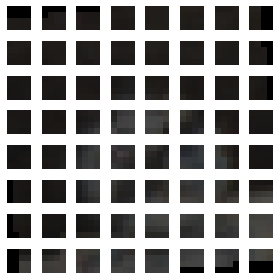

In [6]:
img0_patches = batch_patches[0]

rows = 8
cols = 8
fig, axes = plt.subplots(rows, cols, figsize=(4, 4))
axes = axes.flatten()

for i, patch in enumerate(img0_patches):
    # @ student: reshape the flattened patch back to an image
    patch_ = patch.reshape(4,4,3)
    axes[i].imshow(patch_)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Step 2, 3, 4, 5

The embedding from patches to tokens is a part of our model, hence we will start with the implementation of our model in this step.
To ease the implementation, an already working Transformer class is available in `transformer.py`.
Please use it until you can train your model to convergence.

In [7]:
from transformer import Transformer

class VisionTransformer(nn.Module):
    def __init__(self, *,
                 image_size, patch_size,
                 transformer_dim, transformer_depth, transformer_heads=4, transformer_dim_head=32
     ):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        self.image_size = image_size
        self.patch_size = patch_size

        # @student: Layers for step 2
        patch_dim = 3 * patch_size * patch_size
        self.to_patch_embedding = nn.Sequential(
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, transformer_dim),
            nn.LayerNorm(transformer_dim),
        )

        # @student: Layers for step 3
        # Hint: Use the learned position embedding (using a nn.Parameter)
        num_patches = (image_size // patch_size) * (image_size // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, transformer_dim))

        # @student: Layers for step 4
        self.transformer = Transformer(
            transformer_dim,
            transformer_depth,
            transformer_heads,
            transformer_dim_head,
            transformer_dim * 2
        )

        # @student: Layers for step 5
        self.pred = nn.Linear(transformer_dim, 12)

    def forward(self, image_batch):
        # @student: (step 1) Transform Images into Patches
        patches_batch = transform_batch_into_patches(image_batch, self.patch_size)

        # @student: (step 2) Linear embed Patches into Tokens (Embeddings)
        tokens_batch = self.to_patch_embedding(patches_batch)

        # @student: (step 3) Add Position embedding to Tokens (Embeddings)
        #tokens_batch = tokens_batch + self.pos_embedding

        # @student: (step 4) Feed Tokens (Embeddings) into multiple Transformer Encoder Layer
        # hint: instead of a cls token you can use the mean over the tokens as final embedding per image (Simple ViT) https://arxiv.org/abs/2205.01580
        image_embeddings = self.transformer(tokens_batch)
        image_embeddings = image_embeddings.mean(dim = 1)

        # @student: (step 5)
        return self.pred(image_embeddings)


In [8]:
model = VisionTransformer(
    image_size=32, patch_size=4,
    transformer_dim=48, transformer_depth=6, transformer_heads=8, transformer_dim_head=16
)
print(model)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

VisionTransformer(
  (to_patch_embedding): Sequential(
    (0): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=48, out_features=48, bias=True)
    (2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Transformer(
    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.0, inplace=False)
          (to_qkv): Linear(in_features=48, out_features=384, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=128, out_features=48, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=48, out_features=96, 

In [9]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

def eval(model, dl, with_cm=False):
    y_labels = []
    pred_labels = []
    model.eval()
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(dl):
            logits = model(imgs)

            # @student: calculate class predictions based on the logits
            preds = torch.argmax(torch.softmax(logits, dim=-1), dim=-1)

            pred_labels.extend(preds.detach().numpy())
            y_labels.extend(labels.detach().numpy())

    if with_cm:
        cm = confusion_matrix(y_labels, pred_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
    model.train()
    print(f"f1: {f1_score(y_labels, pred_labels, average='macro')}, p: {precision_score(y_labels, pred_labels, average='macro')}, r: {recall_score(y_labels, pred_labels, average='macro')}")

Below is the training process of the model.
If your machine supports gpu acceleration uncomment line 6.

In [10]:
for epoch in range(10):
    print(f"epoch {epoch+1}")
    pbar = tqdm(enumerate(train_dl))
    running_loss = []
    for i, (imgs, labels) in pbar:
        # @student: uncomment if your machine has GPU support
        #imgs, labels = imgs.to("cuda"), labels.to("cuda")

        optimizer.zero_grad()

        preds = model(imgs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.detach().numpy())
        pbar.set_description(f"loss {np.mean(running_loss):.3} - " )
        pbar.update()
    eval(model, val_dl)


epoch 1


0it [00:00, ?it/s]/home/klemp/miniconda3/envs/mv_assignments/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
loss 1.23 - : : 866it [00:58, 14.80it/s]
/home/klemp/miniconda3/envs/mv_assignments/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start

f1: 0.40203161194209786, p: 0.37604548229548235, r: 0.48333333333333334
epoch 2


loss 0.678 - : : 866it [00:55, 15.48it/s]
/home/klemp/miniconda3/envs/mv_assignments/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1: 0.555503850285634, p: 0.56441887361005, r: 0.6083333333333333
epoch 3


loss 0.526 - : : 866it [18:57,  1.31s/it] 
/home/klemp/miniconda3/envs/mv_assignments/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1: 0.7251933311076534, p: 0.7218510656010656, r: 0.7583333333333333
epoch 4


loss 0.417 - : : 866it [00:46, 18.82it/s]


f1: 0.7610160726512186, p: 0.8025450244200245, r: 0.775
epoch 5


loss 0.377 - : : 866it [00:56, 15.38it/s]


f1: 0.7420200714318361, p: 0.7663179413179413, r: 0.7666666666666666
epoch 6


loss 0.343 - : : 866it [01:22, 10.54it/s]


f1: 0.8384094706463127, p: 0.8466750841750842, r: 0.8416666666666668
epoch 7


loss 0.29 - : : 866it [01:05, 13.32it/s] 


f1: 0.7682388990853567, p: 0.7679178664472782, r: 0.7833333333333333
epoch 8


loss 0.282 - : : 866it [00:56, 15.34it/s]


f1: 0.7810805252688414, p: 0.8213369963369962, r: 0.7916666666666666
epoch 9


loss 0.271 - : : 866it [00:55, 15.51it/s]
/home/klemp/miniconda3/envs/mv_assignments/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1: 0.6395180799592565, p: 0.6810606060606061, r: 0.6749999999999999
epoch 10


loss 0.257 - : : 866it [00:56, 15.44it/s]


f1: 0.7922576668448702, p: 0.8198409161644454, r: 0.8000000000000002


#### From Logits to Labels

Your network will output logits and not the final predictions.
Hence, you further need to calculate the predicted label based on the logits.

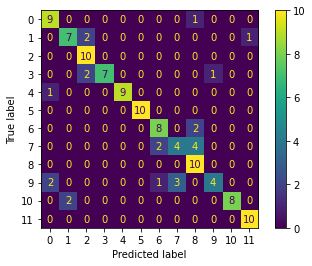

f1: 0.7922576668448702, p: 0.8198409161644454, r: 0.8000000000000002


In [11]:
eval(model, val_dl, with_cm=True)

Once you feel confident with your model evaluate it one last time on the test set.
The test set will be uploaded during the exercise session.

In [12]:
# @student: final check of your fully trained model
test_ds = torchvision.datasets.ImageFolder("data_test", transform=v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
]))
test_dl = DataLoader(dataset=test_ds, batch_size=16, shuffle=False)

eval(model, test_dl)

f1: 0.8309659644983207, p: 0.8537841325667078, r: 0.8279327412783295
